In [1]:
import numpy as np
import random
import datetime
import time
import os
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import hdbscan
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
import pandas as pd
import seaborn as sns
import colorcet as cc
from sklearn.manifold import TSNE


import argparse
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader

from ember_utils import *
from ember_model import *
from ember_pjr_utils import *

In [2]:
stored_global_family_dict = defaultdict(list)

In [9]:
def get_HDBScanBased_samples(family_name, family_data, num_samples_per_malware_family):
    data_X = np.array(family_data)
    
    if len(data_X) > 1:
        
        # fit the model
        clf = hdbscan.HDBSCAN()
        clf_labels = clf.fit_predict(data_X)

        anomalous_idx = np.where(clf_labels == -1)
        similar_idx = np.where(clf_labels != -1)

        assert len(anomalous_idx[0]) + len(similar_idx[0]) == len(data_X)

        anomalous_samples = data_X[anomalous_idx]
        remaining_samples_to_pick = num_samples_per_malware_family - len(anomalous_samples)

        if remaining_samples_to_pick >= len(similar_idx):
            similar_samples = data_X[similar_idx]
        else:
            similar_samples_pool = list(data_X[similar_idx])
            try:
                similar_samples = random.sample(similar_samples_pool, remaining_samples_to_pick)
            except:
                print(f'{family_name} has {len(anomalous_idx[0])} anomalous (-1) samples')
                #print(f'samples to pick {remaining_samples_to_pick} pool samples {len(similar_samples_pool)}')
                #print()
                
                similar_samples = random.sample(similar_samples_pool, abs(remaining_samples_to_pick))

        replay_samples = np.concatenate((anomalous_samples, similar_samples))
    else:
        replay_samples = data_X
    
    return np.array(replay_samples)



def get_HDBScanCluster(global_family_dict, num_samples_per_malware_family, selected_families):
    
    tmp_family_dict = defaultdict(list)
    #pre_malware_samples = []

    
    for k, v in global_family_dict.items():
        if k != 'goodware' and k in selected_families:
            selected_family_samples = get_HDBScanBased_samples(k, v, num_samples_per_malware_family)
            tmp_family_dict[k] = list(selected_family_samples)
            
            #print(selected_family_samples)
            #for sample in selected_family_samples:
            #    pre_malware_samples.append(sample)
                
    #if len(global_family_dict['goodware']) < len(pre_malware_samples):
    #    pre_goodware_samples = random.sample(global_family_dict['goodware'], len(global_family_dict['goodware']))
    #else:
    #    pre_goodware_samples = random.sample(global_family_dict['goodware'], len(pre_malware_samples))
    
    #tmp_family_dict['goodware'] = list(pre_goodware_samples)
    
    
    return tmp_family_dict



all_task_months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
                   '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']

data_dir = '../../month_based_processing_with_family_labels/'

num_exps = 1
num_epoch = 1
batch_size = 6000
num_samples_per_malware_family = 500

exp_type = 'HDBScanBased'

exp_seeds = [random.randint(1, 99999) for i in range(num_exps)]

start_time = time.time()


start_task = 0
end_task = 12


emotet_samples = {}

for task_month in range(start_task, end_task):

    print(f'\n{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} ...')
    task_start = time.time()

    #task_month = task_month
    current_task = all_task_months[task_month]
    task_months = all_task_months[:task_month+1]
    print(f'Current Task {current_task} w/ {num_samples_per_malware_family} samples to Replay per Malware family.')


    X_train, Y_train, Y_train_family = get_family_labeled_month_data(data_dir, current_task)
    X_test, Y_test, Y_test_family = get_family_labeled_task_test_data(data_dir, task_months, mlp_net=True)        
    
    
    if current_task == all_task_months[0]:
        #num_replay_samples = 0
        stored_global_family_dict = make_family_based_dict(X_train, Y_train, Y_train_family,\
                                                           current_task, stored_global_family_dict)
    else:
        #tmp_family_dict = get_HDBScanCluster(stored_global_family_dict, num_samples_per_malware_family, top_10_fam)

        stored_global_family_dict = make_family_based_dict(X_train, Y_train, Y_train_family,\
                                                           current_task, stored_global_family_dict)
    
    num_emotet_samples = len(stored_global_family_dict['emotet'])
    print(f'#of emotet samples {num_emotet_samples}')
    
    emotet_samples[current_task] = stored_global_family_dict['emotet']
    
    


2023-02-19 15:09:18 ...
Current Task 2018-01 w/ 500 samples to Replay per Malware family.
X_train (55722, 2381) Y_train (55722,) Y_tr_family (55722,)
X_test (6192, 2381) Y_test (6192,) Y_te_family (6192,)
Task 2018-01 and #-of new samples stored 55722
#of emotet samples 13279

2023-02-19 15:09:19 ...
Current Task 2018-02 w/ 500 samples to Replay per Malware family.
X_train (48723, 2381) Y_train (48723,) Y_tr_family (48723,)
X_test (11606, 2381) Y_test (11606,) Y_te_family (11606,)
Task 2018-02 and #-of new samples stored 48723
#of emotet samples 13865

2023-02-19 15:09:21 ...
Current Task 2018-03 w/ 500 samples to Replay per Malware family.
X_train (37372, 2381) Y_train (37372,) Y_tr_family (37372,)
X_test (15759, 2381) Y_test (15759,) Y_te_family (15759,)
Task 2018-03 and #-of new samples stored 37372
#of emotet samples 14555

2023-02-19 15:09:22 ...
Current Task 2018-04 w/ 500 samples to Replay per Malware family.
X_train (46873, 2381) Y_train (46873,) Y_tr_family (46873,)
X_test (2

In [12]:
emotet_samples.keys()

dict_keys(['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12'])

In [4]:
top_10_fam = ['xtrat',
 'zbot',
 'ramnit',
 'sality',
 'installmonster',
 'zusy',
 'emotet',
 'vtflooder',
 'others_family',
 'fareit']

In [22]:
start = time.time()

clf = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clf_labels = clf.fit(emotet_samples)

print(f'time taken {(time.time() - start)/ 60} mins')

/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/hdbscan/hdbscan_.py:219: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


time taken 20.22071849902471 mins


<AxesSubplot:ylabel='distance'>

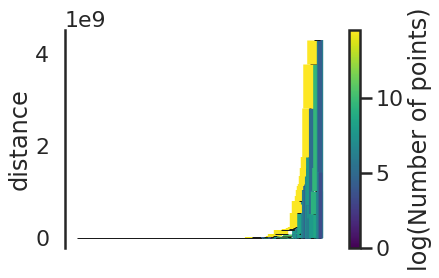

In [25]:
clf_labels.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

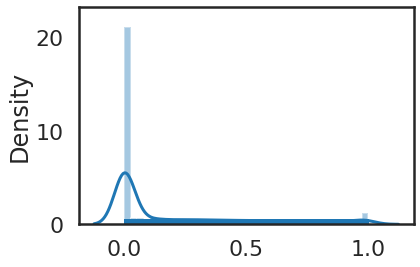

In [27]:
sns.distplot(clf_labels.outlier_scores_[np.isfinite(clf_labels.outlier_scores_)], rug=True)

242


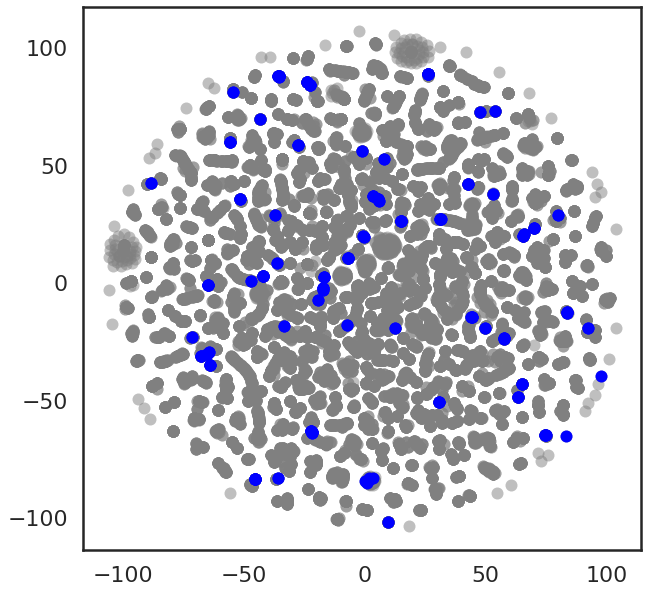

In [52]:
threshold = pd.Series(clf_labels.outlier_scores_).quantile(0.99)
outliers = np.where(clf_labels.outlier_scores_ > threshold)[0]

print(len(outliers))

plt.figure(figsize=(10, 10))
plt.scatter(*embedded.T, linewidth=0, c='gray', alpha=.50)
plt.scatter(*embedded[outliers].T,linewidth=0, c='blue', alpha=1.0)

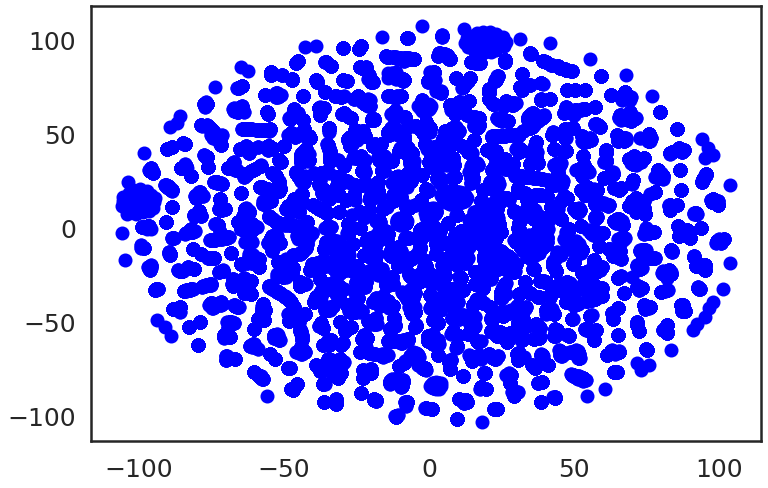

In [20]:
            sns.set_context('poster')
            sns.set_style('white')
            sns.set_color_codes()



            plt.figure(figsize=(12, 8))

            save_file_name = 'emotet_' + str(task_month)  + '_hdbscan.png'

            plot_kwds = {'alpha' : 1.0, 's' : 100, 'linewidths':2}
            plt.scatter(embedded.T[0], embedded.T[1], color='blue');

            plt.xticks(fontsize=25);
            plt.yticks(fontsize=25);

/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


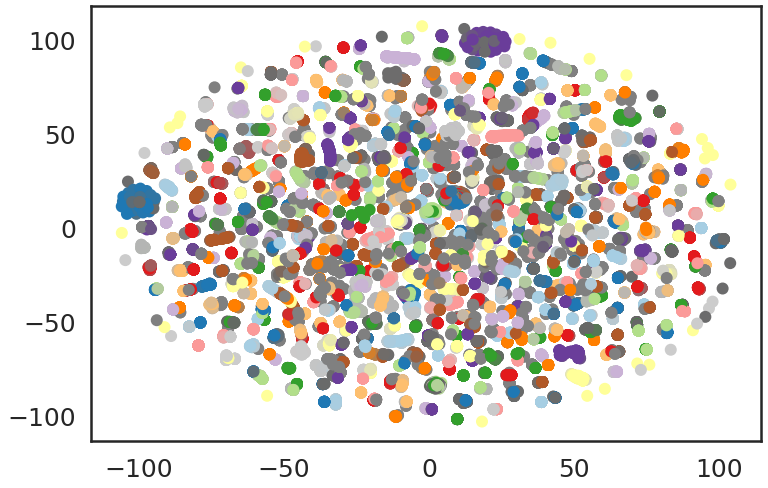

In [14]:
# emotet_samples


for emotet_task, emotet_samples in emotet_samples.items():
    
    if emotet_task == '2018-01':
        try:
            clf = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
            clf_labels = clf.fit(emotet_samples)

            tsne = TSNE(random_state=123)
            embedded = tsne.fit_transform(emotet_samples)

            unique_labels = len(np.unique(clf_labels.labels_))

            sns.set_context('poster')
            sns.set_style('white')
            sns.set_color_codes()

            palette = sns.color_palette(sns.color_palette("Paired", unique_labels))
            cluster_colors = [sns.desaturate(palette[col], sat)
                              if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                              zip(clf_labels.labels_, clf_labels.probabilities_)]

            plt.figure(figsize=(12, 8))

            save_file_name = 'emotet_' + str(task_month)  + '_hdbscan.png'

            plot_kwds = {'alpha' : 1.0, 's' : 100, 'linewidths':2}
            plt.scatter(embedded.T[0], embedded.T[1], c=cluster_colors, **plot_kwds);

            plt.xticks(fontsize=25);
            plt.yticks(fontsize=25);
            #plt.xlabel(f'Anomaly Scores', fontsize=25)
            #plt.ylabel(f'#of Samples', fontsize=25)


            #plt.title(f"HDBSCAN Labeled Cluster : {fam}", fontsize=30)
            plt.savefig('./figs_proposal/' + save_file_name, bbox_inches='tight');
        except: pass
    
    

In [ ]:
for famName in top_10_fam:
    try:
        fam = famName

        data_X = stored_global_family_dict[fam]

        clf = hdbscan.HDBSCAN()
        clf_labels = clf.fit(data_X)

        tsne = TSNE(random_state=123)
        embedded = tsne.fit_transform(data_X)

        unique_labels = len(np.unique(clf_labels.labels_))

        sns.set_context('poster')
        sns.set_style('white')
        sns.set_color_codes()

        palette = sns.color_palette(sns.color_palette("Paired", unique_labels))
        cluster_colors = [sns.desaturate(palette[col], sat)
                          if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                          zip(clf_labels.labels_, clf_labels.probabilities_)]

        plt.figure(figsize=(12, 8))

        save_file_name = fam + '_' + str(task_month)  + '_hdbscan.png'

        plot_kwds = {'alpha' : 1.0, 's' : 100, 'linewidths':2}
        plt.scatter(embedded.T[0], embedded.T[1], c=cluster_colors, **plot_kwds);

        plt.xticks(fontsize=25);
        plt.yticks(fontsize=25);
        #plt.xlabel(f'Anomaly Scores', fontsize=25)
        #plt.ylabel(f'#of Samples', fontsize=25)


        plt.title(f"HDBSCAN Labeled Cluster : {fam}", fontsize=30)
        plt.savefig('./figures/hdbscan/' + save_file_name,
                        bbox_inches='tight');
    except: pass

/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' i